# Compare resolution obtained with Z and with Zrms

## Scope 

- This NB computes XY maps using MC data and both Z (from S1-S2 drift distance) and Zrms (from S2rms)



### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/ICAROS/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun Feb 24 23:32:33 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-02-24 23:32:35,038 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"


input_file_names  = [f'Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5']

time_bins = 1
output_file_name  = ' '
map_file_name     = ''
map_file_name_ts  = ''
emap_file_name    = f'kr_emap_xy_50_50_mc.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import data_frames_are_identical

In [10]:
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins

In [11]:
from krcal.core.kr_types            import PlotLabels, FitType

In [12]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [13]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [14]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [15]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [16]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [17]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [18]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [19]:
from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_rphi_sectors_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.selection_functions  import get_time_series_df
from krcal.core.fitmap_functions     import time_fcs_df
from krcal.core.fitmap_functions     import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

In [20]:
import krcal.dev.corrections       as corrections 


In [21]:
from numpy import pi, sqrt

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [22]:
import logging
log = logging.getLogger()

### Input/output 

In [23]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [24]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_50_50_mc.h5')

In [25]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [26]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 7505736


In [27]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [28]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 15000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [29]:
krRanges

KrRanges(S2e=(2000, 14000), S1e=(3, 25), S2q=(200, 800), X=(-200, 200), Y=(-200, 200), Z=(10, 550), T=(0, 7505736))

In [30]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=50, Y=50, Z=15, T=2084)

### Sort DST in time and add DT column (DT is a vector of time differences)

In [31]:
T       = np.arange(len(dst))
DT      = time_delta_from_time(T)

In [32]:
dst = dst.assign(DT=DT)

In [33]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

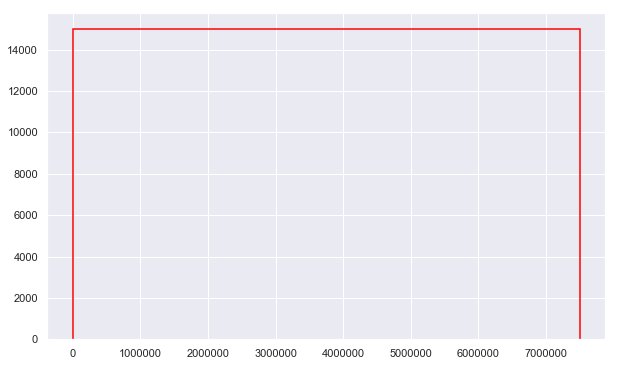

In [34]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst.DT.values, bins=500, range = (dst.DT.values[0], dst.DT.values[-1]), color='red', stats=False, lbl='pre-sel')

#### NB: Variable rate from Krypton

### Time 

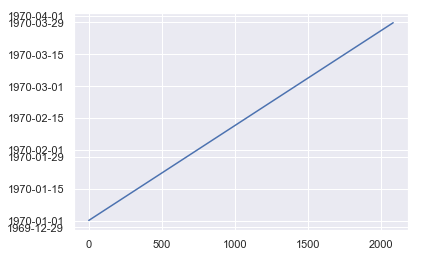

In [35]:
plt.plot(krTimes.timeStamps)

### Fiducial cut

In [36]:
dst = dst[in_range(dst.R, 0, RMAX)]

### Event distribution

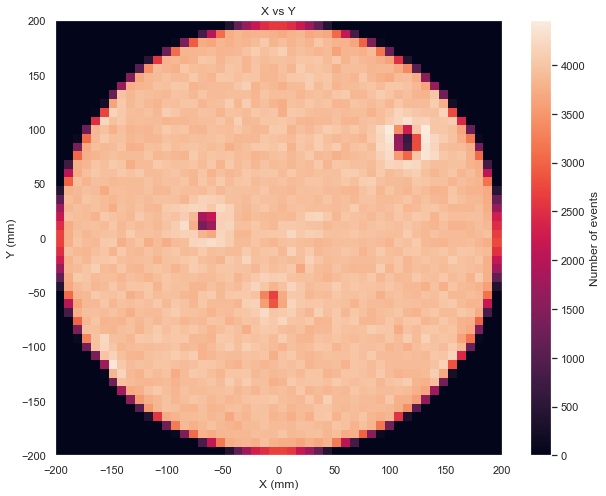

In [37]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Fit lifetime of the time series in the fiducial volume ( R < 180 cm) 

In [42]:
dstfid = dst[in_range(dst.R, 0, RFID)]

## Time series

In [43]:
ti = timeit(get_time_series_df)
ts, masks = ti(time_bins, (DT[0],DT[-1]), dstfid)

Time spent in get_time_series_df: 0.01665496826171875 s


In [46]:
ti = timeit(time_fcs_df)
fps = ti(ts, masks, dstfid, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 18000),
         energy  = 'S2e',
         fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

Time spent in time_fcs_df: 1.336789846420288 s


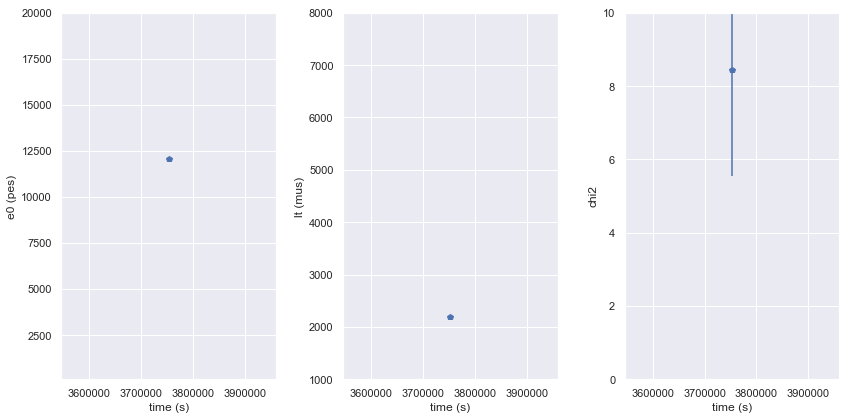

In [48]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (100,20000),
              range_lt    = (1000, 8000),
              figsize     = (12,6))

## Single time XY map. 

- Compute a single-time (or time-averaged) map, with a fine-grain in XY. 
- The energy map (e0 correction) is invariant and can be added for many maps.
- The lt map (lt correction) represents an average-over-run. A correction function may use such a map or add a time-dependent correction, fitting the time dependence. 

## Divide chamber in sectors of XY

In [38]:
log.setLevel(logging.DEBUG) # turn to DEBUG to follow progress of this part 

In [39]:
ti = timeit(select_xy_sectors_df)
KXY = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 10.196969032287598 s


In [40]:
nXY = event_map_df(KXY)

2019-02-24 23:34:12,532 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x1a1ea2e320>
2019-02-24 23:34:12,533 | DEBUG : Using auto colorbar locator on colorbar
2019-02-24 23:34:12,534 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x1a1ea2e320>
2019-02-24 23:34:12,535 | DEBUG : Setting pcolormesh
2019-02-24 23:34:12,563 | DEBUG : update_title_pos
2019-02-24 23:34:12,602 | DEBUG : update_title_pos
2019-02-24 23:34:12,630 | DEBUG : update_title_pos
2019-02-24 23:34:12,654 | DEBUG : update_title_pos
2019-02-24 23:34:12,665 | DEBUG : update_title_pos
2019-02-24 23:34:12,689 | DEBUG : update_title_pos
2019-02-24 23:34:12,708 | DEBUG : update_title_pos
2019-02-24 23:34:12,722 | DEBUG : update_title_pos
2019-02-24 23:34:12,751 | DEBUG : update_title_pos
2019-02-24 23:34:12,771 | DEBUG : update_title_pos
2019-02-24 23:34:12,780 | DEBUG : update_title_pos
2019-02-24 23:34:12,807 | DEBUG : update_title_pos


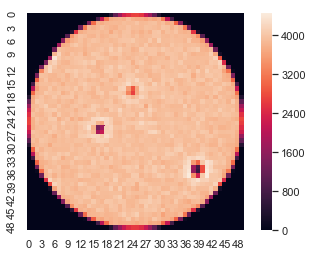

In [41]:
ax = sns.heatmap(nXY, square=True)

In [42]:
log.setLevel(logging.INFO) 

## Fits in XY sectors

## Maps

#### The first step is to fit a map XY (in time series) for the number of time bins required (in this case 1)

In [43]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy2 = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 7.993430852890015 s


#### The second step is to obtain the maps themselves from the fit-map-XY

In [44]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy2)

Time spent in tsmap_from_fmap: 0.0017528533935546875 s


#### Third step: select the corresponding map in the time series (in this case just one, ts=0)

In [45]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

#### Am contains the maps in XY bins for the single time series (ts=0). We can now compute the map average, draw, etc:

In [46]:
amap_average(am) 

ASectorMap(chi2=1.0822222146742266, e0=11057.65573040042, lt=2120.9392792881354, e0u=14.436689759768434, ltu=19.74133727769164, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [47]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-02-24 23:34:58,398 | INFO :  set nans to average value of interval = 10000.0
2019-02-24 23:34:58,455 | INFO :  set nans to average value of interval = 3500.0


In [48]:
amap_average(rmap)

ASectorMap(chi2=1.0822222146742266, e0=11057.65573040042, lt=2120.9392792881354, e0u=14.436689759768434, ltu=19.74133727769164, mapinfo=None)

In [49]:
asm = relative_errors(rmap)

In [50]:
amv = amap_average(asm)
amv

ASectorMap(chi2=1.0822222146742266, e0=11057.65573040042, lt=2120.9392792881354, e0u=0.14733982883634644, ltu=0.9215830538345897, mapinfo=None)

#### Draw the maps using default colormap

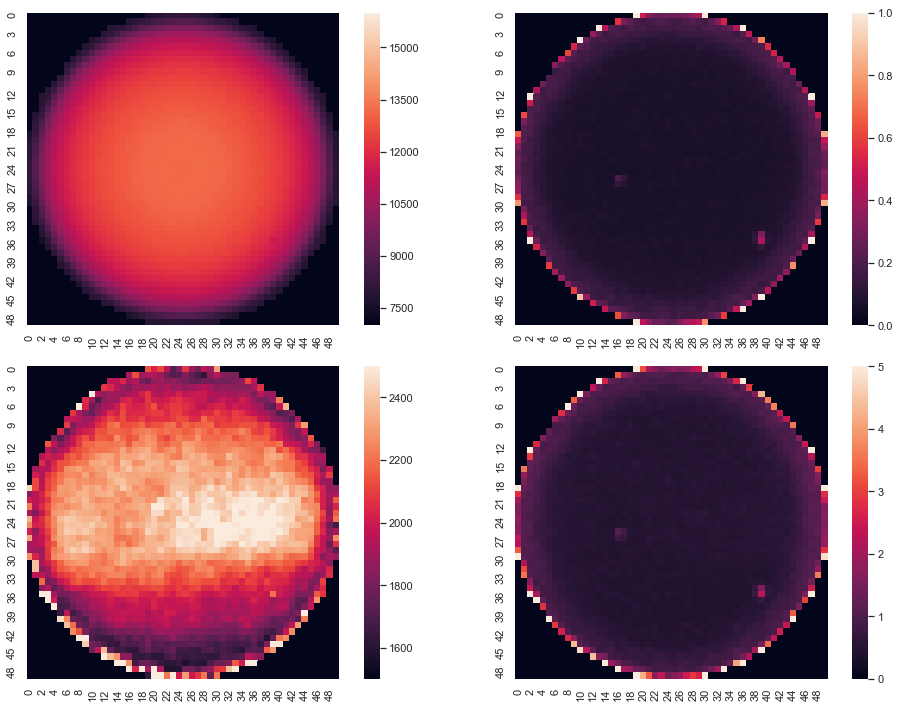

In [51]:
draw_xy_maps(asm,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [52]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [53]:
amap_average(asmAv)

ASectorMap(chi2=1.0837074981999164, e0=11305.792066225373, lt=2128.3032913284846, e0u=0.13232473088488927, ltu=0.830985973505604, mapinfo=None)

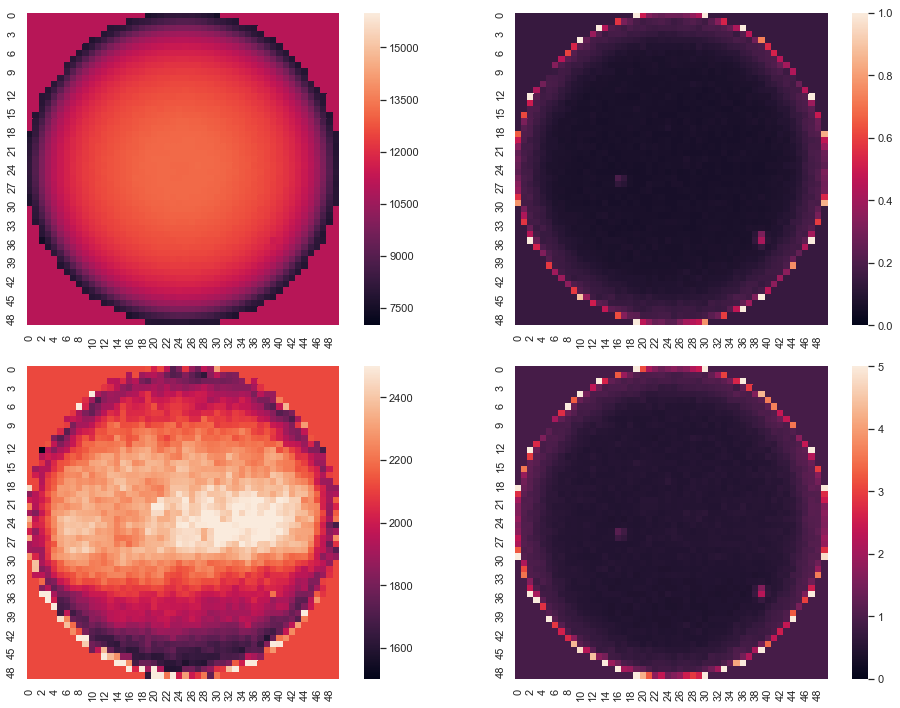

In [54]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [55]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=-6400)

In [56]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number   -6400
dtype: int64

### Save to file

In [57]:
write_maps(asm, filename=fn.emap_file_name)

### Read back

In [58]:
fn.emap_file_name

'/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_50_50_mc.h5'

In [59]:
emaps = read_maps(filename=fn.emap_file_name)

In [60]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number   -6400
dtype: int64

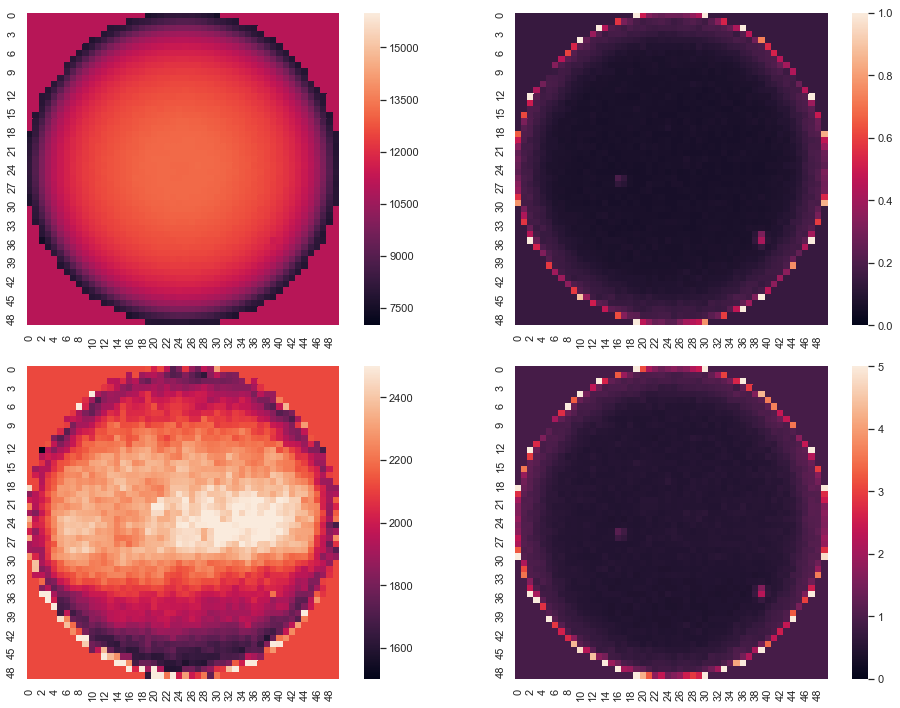

In [61]:
draw_xy_maps(emaps,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

## Now check the corrections that can be achieved with the single maps

In [62]:
amap_average(emaps)

ASectorMap(chi2=1.0837074981999164, e0=11305.792066225373, lt=2128.3032913284846, e0u=0.13232473088488927, ltu=0.830985973505604, mapinfo=None)

In [63]:
norm = amap_max(emaps)

In [64]:
norm

ASectorMap(chi2=4.726677844623, e0=13188.162174220006, lt=5885.775261843065, e0u=2.7939829484426393, ltu=22.603621256789708, mapinfo=None)

#### E0 correction:

In [65]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 62.406591176986694 s


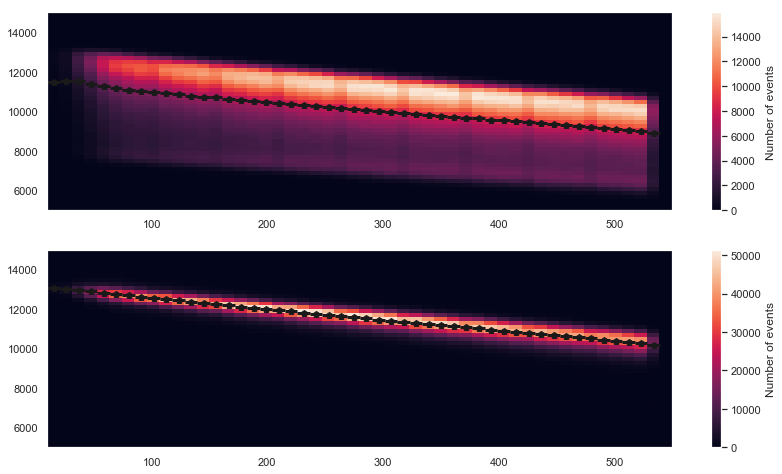

In [66]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

## XY (single time) LT correction

In [67]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 63.39250206947327 s


In [68]:
er = (5000,15000)

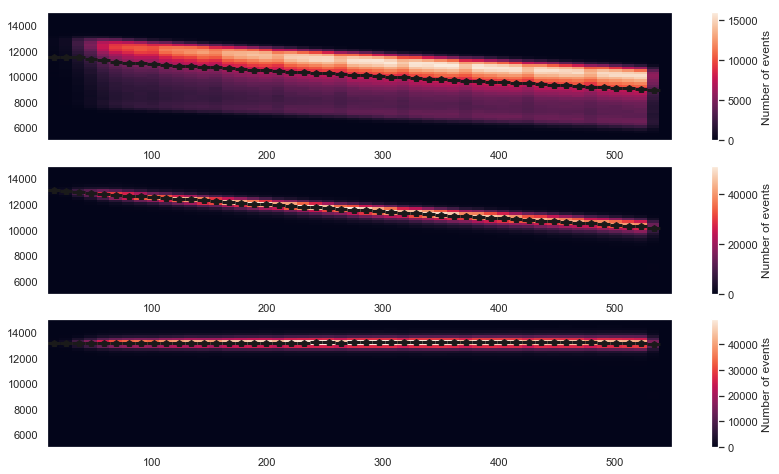

In [69]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

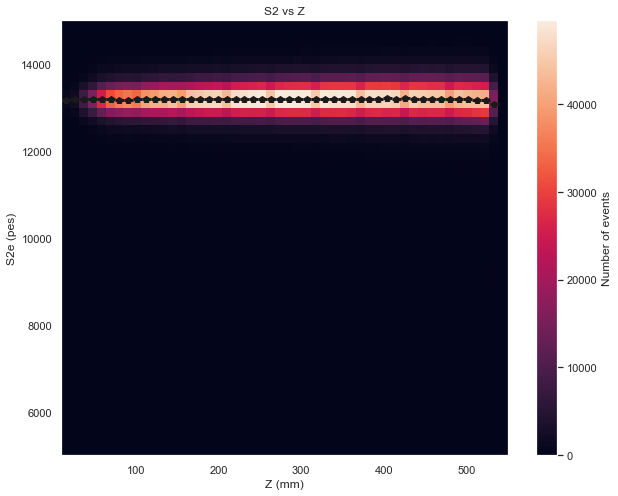

In [70]:
nevt = h2d(dst.Z, E, 50, 50, krRanges.Z, (5000,15000),  
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

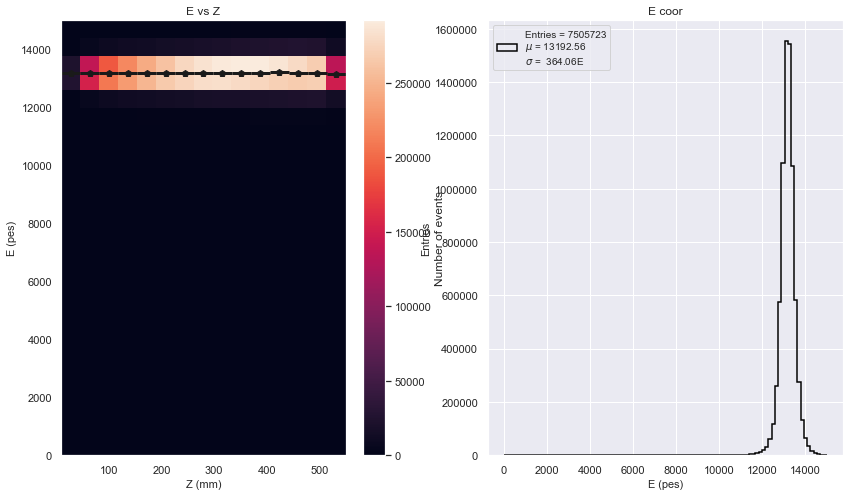

In [71]:
e_range = (0, 15000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 13204.15781133034 +-0.10804876670767521 
 E sigma   = 281.764003675141 +-0.09000756703574833 
 chi2    = 26.155863227159255 
 sigma E/E (FWHM)     (%) =5.014673545240438
 sigma E/E (FWHM) Qbb (%) =0.6476548987946843 


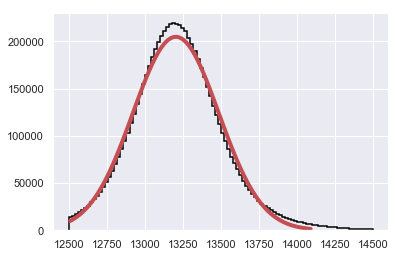

In [72]:
fc = fit_energy(E, nbins=100, range=(12500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

In [73]:
baseline = 12500
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(T, E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(e1, e2),
                    figsize=(12,6))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7505723 but corresponding boolean dimension is 7505736

<Figure size 864x432 with 0 Axes>

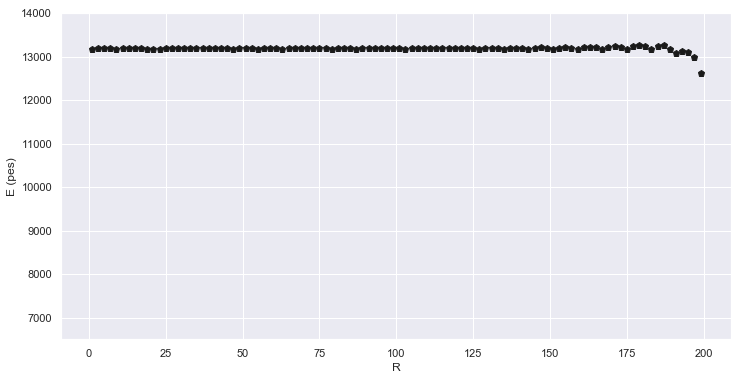

In [74]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

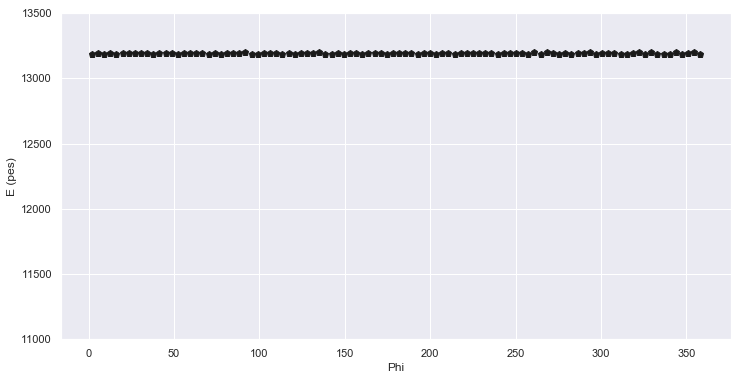

In [75]:
energy_X_profile(phirad_to_deg(dst.Phi), E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

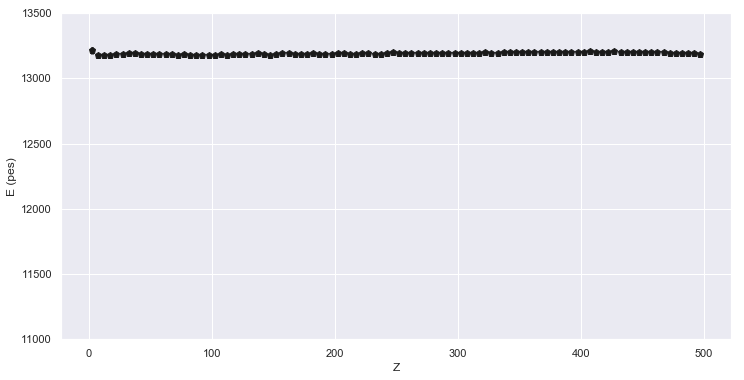

In [76]:
energy_X_profile(dst.Z, E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

### Select events in the region

- R < 180
- 10 < z < 550
- 11000 < E < 13500

In [77]:
dst = dst.assign(E=E)

In [78]:
RFID = 175
dst_R     = dst[dst.R < RFID]

### Repeat profles

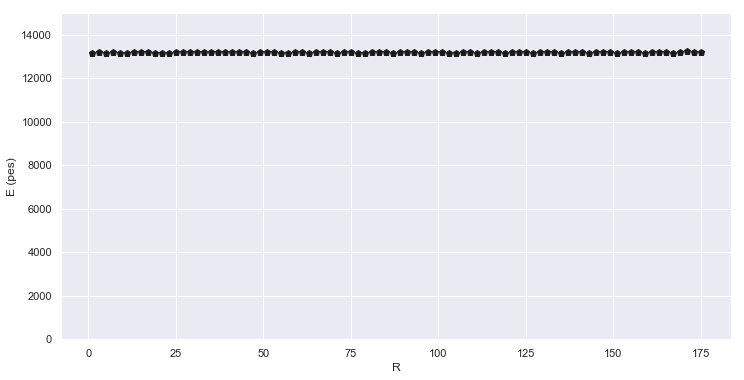

In [79]:
energy_X_profile(dst_R.R, dst_R.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

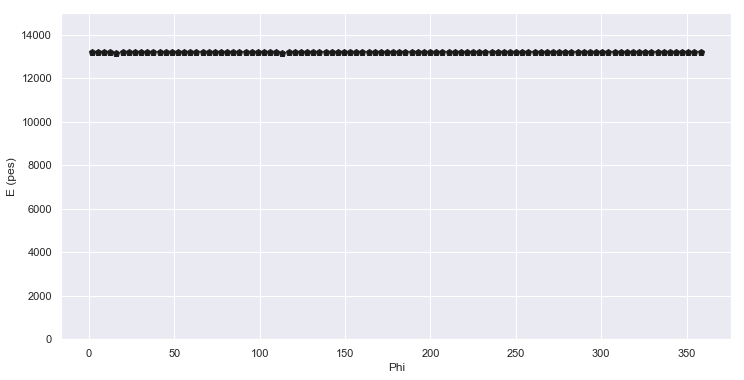

In [80]:
energy_X_profile(phirad_to_deg(dst_R.Phi), dst_R.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))

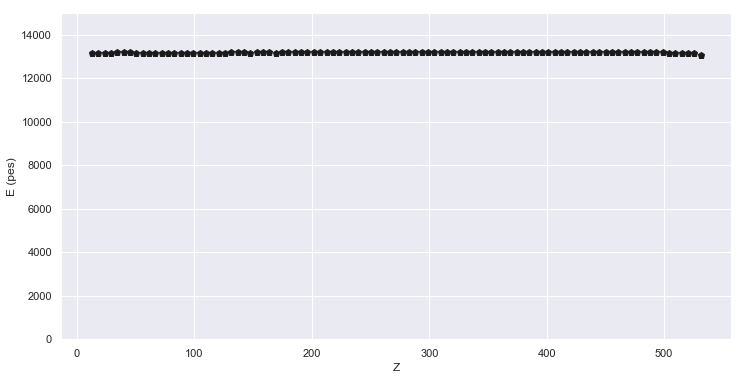

In [81]:
energy_X_profile(dst_R.Z, dst_R.E, xnbins = 100, xrange=zrange, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))

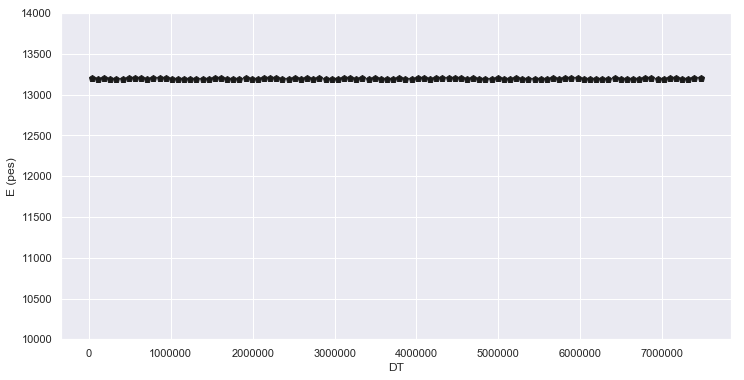

In [82]:
energy_X_profile(dst_R.DT, dst_R.E, xnbins = 100, xrange=(dst_R.DT.values[0], dst_R.DT.values[-1]), xlabel = 'DT',
                 erange=(10000,14000),   
                 figsize=(12,6))

#### Everything is flat. No need for further corrections. 

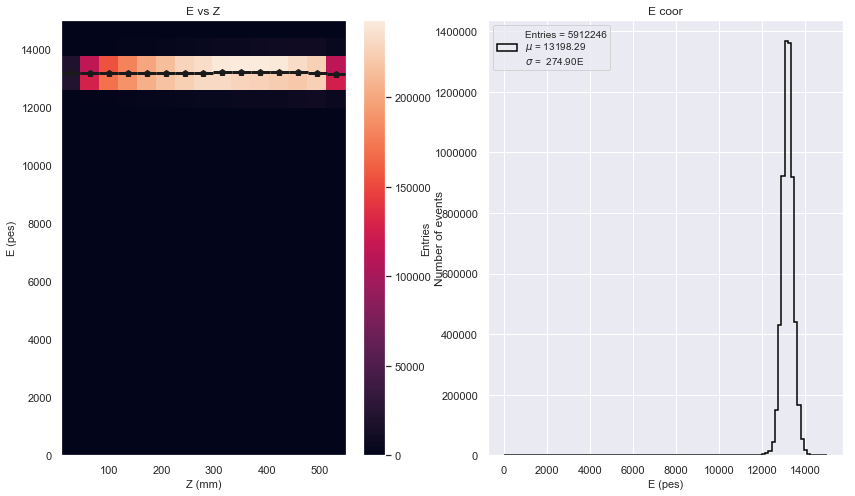

In [83]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst_R.Z, dst_R.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst_R.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 13202.978569889046 +-0.10402294203706795 
 E sigma   = 247.2850207571404 +-0.08120915013919242 
 chi2    = 10.950289333640226 
 sigma E/E (FWHM)     (%) =4.4014295388208255
 sigma E/E (FWHM) Qbb (%) =0.5684532356493125 


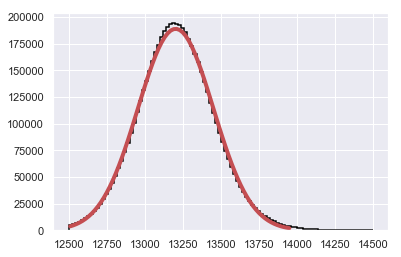

In [84]:
fc = fit_energy(dst_R.E, nbins=100, range=(12500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

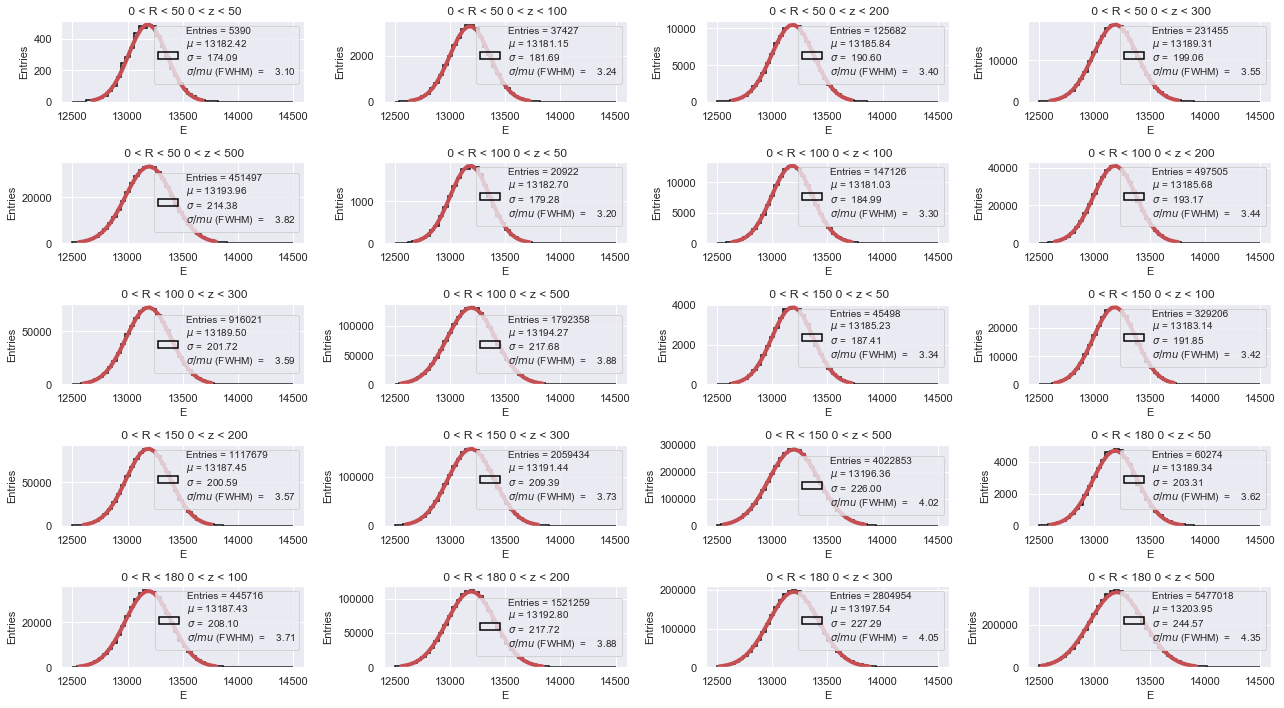

In [85]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, dst_R.R, dst_R.Z, dst_R.E,
                    enbins = 50,
                    erange = (12500,14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

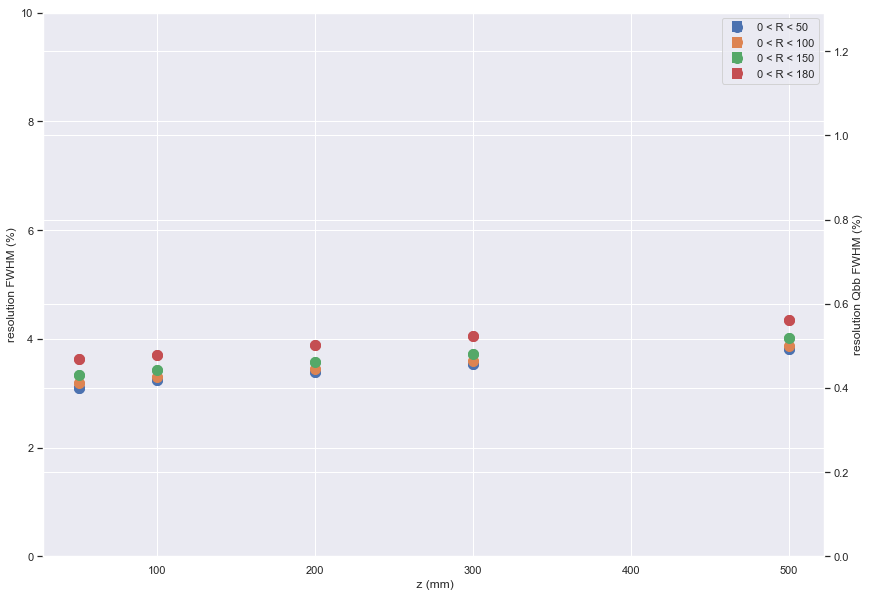

In [86]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

## Now repeat the exercize for ZRms

In [87]:
dst = dst_R

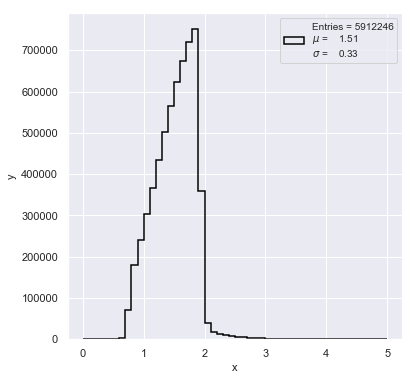

In [88]:
(_) = h1d(dst.Zrms, bins = 50, range =(0,5))

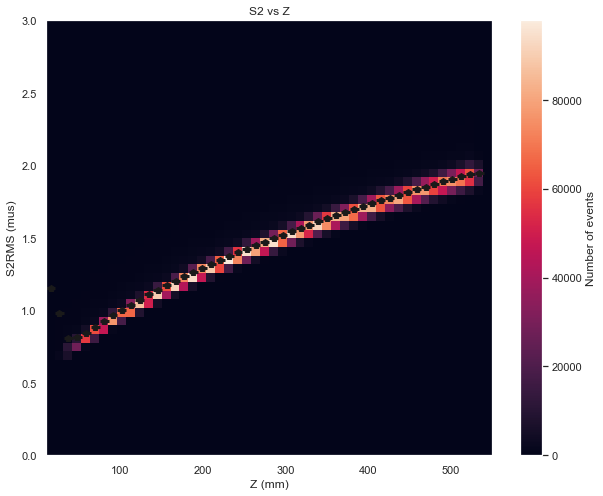

In [89]:
nevt = h2d(dst.Z, dst.Zrms, 50, 50, (10,550), (0,3), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

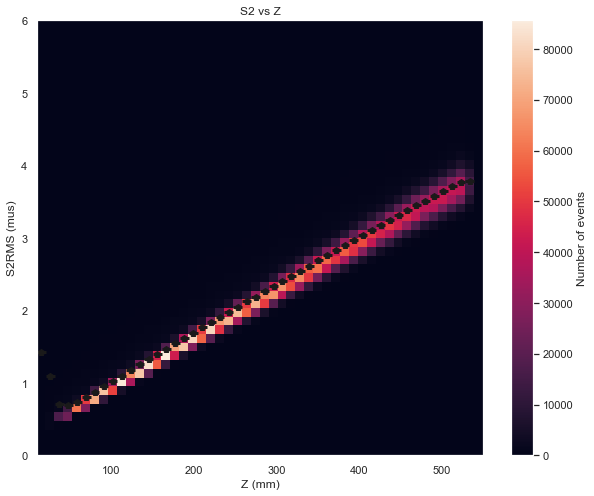

In [91]:
nevt = h2d(dst.Z, dst.Zrms * dst.Zrms, 50, 50, (10,550), (0,6), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [95]:
from krcal.core.histo_functions import profile1d
from krcal.core import fit_functions_ic as fitf

In [94]:
x, y, yu  = profile1d(dst.Z, dst.Zrms * dst.Zrms, 20, range_z=(50, 500))

In [96]:
fh     = fitf.fit(fitf.polynom, x, y, seed=(1,1), fit_range=(10,500), sigma=0.005*y)

In [97]:
fh

FitFunction(fn=<function fit.<locals>.<lambda> at 0x1b17775a60>, values=array([0.35777807, 0.00664817]), errors=array([3.19163063e-03, 1.64807831e-05]), chi2=1.2168203424394375, pvalue=0.2363306364121333, cov=array([[ 1.01865061e-05, -4.36035612e-08],
       [-4.36035612e-08,  2.71616210e-10]]))

Text(0, 0.5, 'Zrms2')

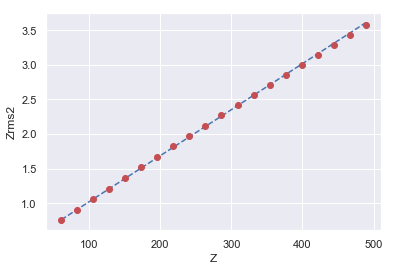

In [98]:
plt.errorbar(x, y,  yerr=0.01*y, fmt='ro')
plt.plot(x, fh.fn(x), 'b--')
plt.xlabel('Z')
plt.ylabel('Zrms2')

In [99]:
def z_from_s2rms(s2rms : np.array,  fh)->np.array:
    zr = (s2rms * s2rms - fh.values[0]) / fh.values[1]
    return zr 

In [101]:
zs2 = z_from_s2rms(dst.Zrms, fh)

In [102]:
dst = dst.assign(ZS2=zs2)

In [104]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms', 'E', 'ZS2'],
      dtype='object')

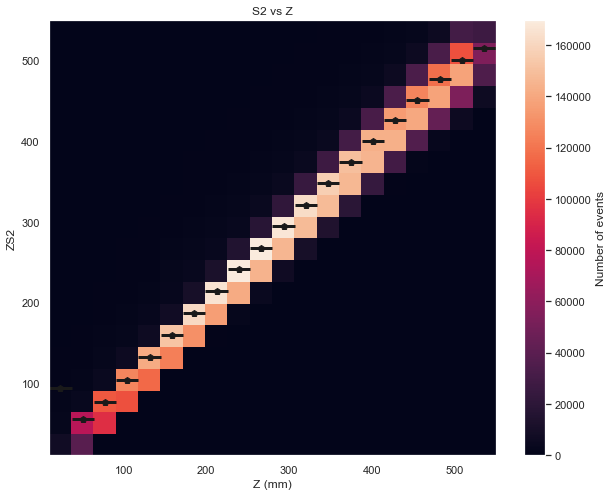

In [113]:
nevt = h2d(dst.Z, dst.ZS2, 20, 20, (10,550), (10,550), 
           pltLabels=PlotLabels(x='Z (mm)', y='ZS2', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [106]:
ti = timeit(select_xy_sectors_df)
KXY2 = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 10.226921319961548 s


In [107]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY2,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'ZS2',
              fit            = FitType.unbined,
              n_min          = 100)

2019-02-24 23:47:57,836 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,839 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,841 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,843 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,845 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,848 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,850 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,852 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,855 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-02-24 23:47:57,858 | WARNING : Type error found in fit_life

In [114]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.003423929214477539 s


In [115]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
amap_average(am) 

ASectorMap(chi2=9.160280579491662, e0=11540.57562024984, lt=2877.3385626820996, e0u=21.24429081981695, ltu=41.93719233408182, mapinfo=None)

In [116]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)
amap_average(rmap)
asm = relative_errors(rmap)
amv = amap_average(asm)
amv

2019-02-24 23:56:07,090 | INFO :  set nans to average value of interval = 7500.0
2019-02-24 23:56:07,146 | INFO :  set nans to average value of interval = 3500.0


ASectorMap(chi2=9.160280579491662, e0=11540.57562024984, lt=2877.3385626820996, e0u=0.19182161152704721, ltu=1.5180419026140333, mapinfo=None)

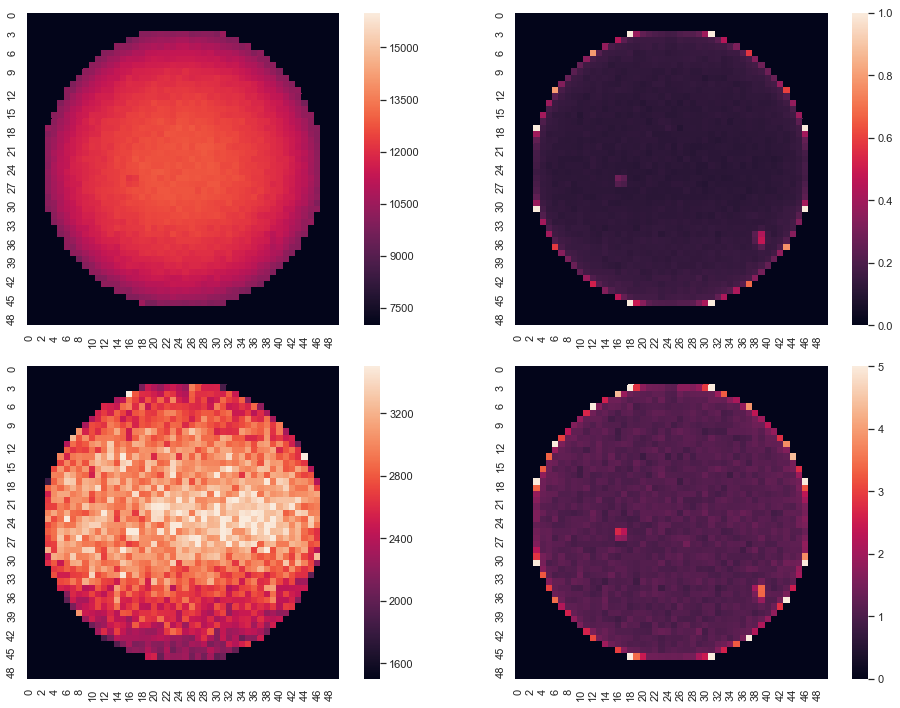

In [118]:
draw_xy_maps(asm,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 3500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [119]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=-6400)

In [121]:
norm = amap_max(asm)

In [122]:
norm

ASectorMap(chi2=4.726677844623, e0=13188.162174220006, lt=5885.775261843065, e0u=2.7939829484426393, ltu=22.603621256789708, mapinfo=None)

In [123]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = asm.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 55.78444480895996 s


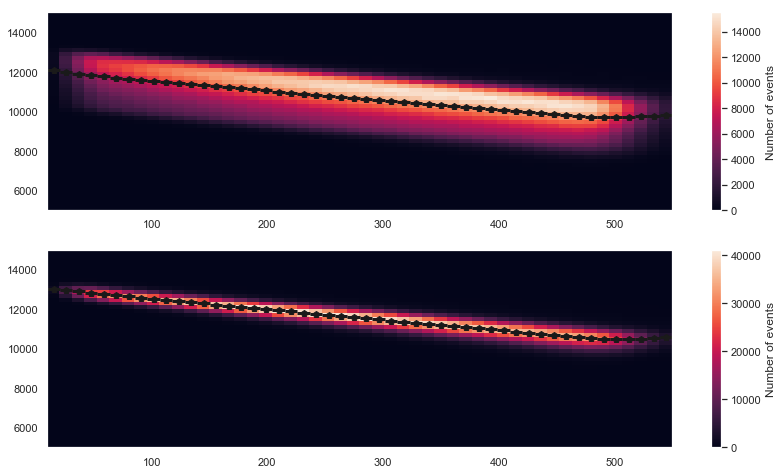

In [127]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.ZS2, dst.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.ZS2, E0, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

In [132]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.ZS2.values, 
       LTM = asm.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 50.39001798629761 s


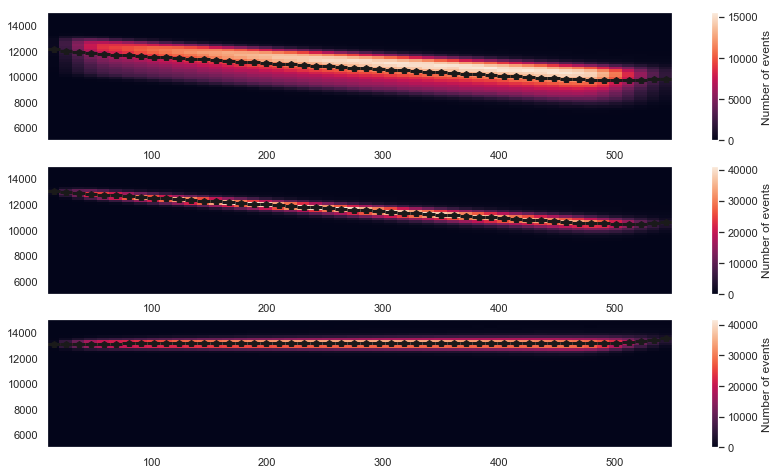

In [133]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.ZS2, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.ZS2, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.ZS2, E, 50, 50, krRanges.Z, er, 
           profile=True)

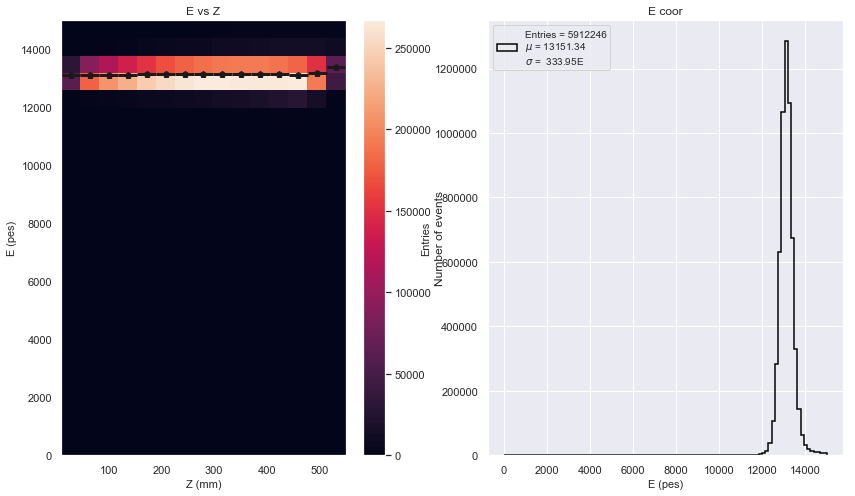

In [134]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.ZS2, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 13139.317638289713 +-0.11929561476219072 
 E sigma   = 272.7433415014738 +-0.09895423283313506 
 chi2    = 17.785614943095915 
 sigma E/E (FWHM)     (%) =4.878083247342004
 sigma E/E (FWHM) Qbb (%) =0.6300139946034815 


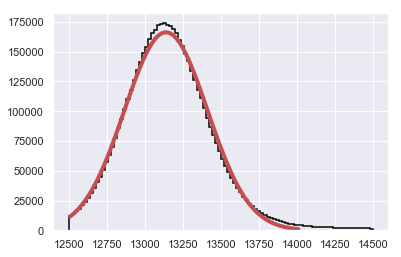

In [135]:
fc = fit_energy(E, nbins=100, range=(12500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

 fit failed for seed  = GaussPar(mu=Measurement(value=13132.227158285537, uncertainty=0.18474654332442048), std=Measurement(value=232.4786226596012, uncertainty=0.13063557483491878), amp=Measurement(value=109411.80415671655, uncertainty=0.3274548255538814)), due to RunTimeWarning, retry fit 


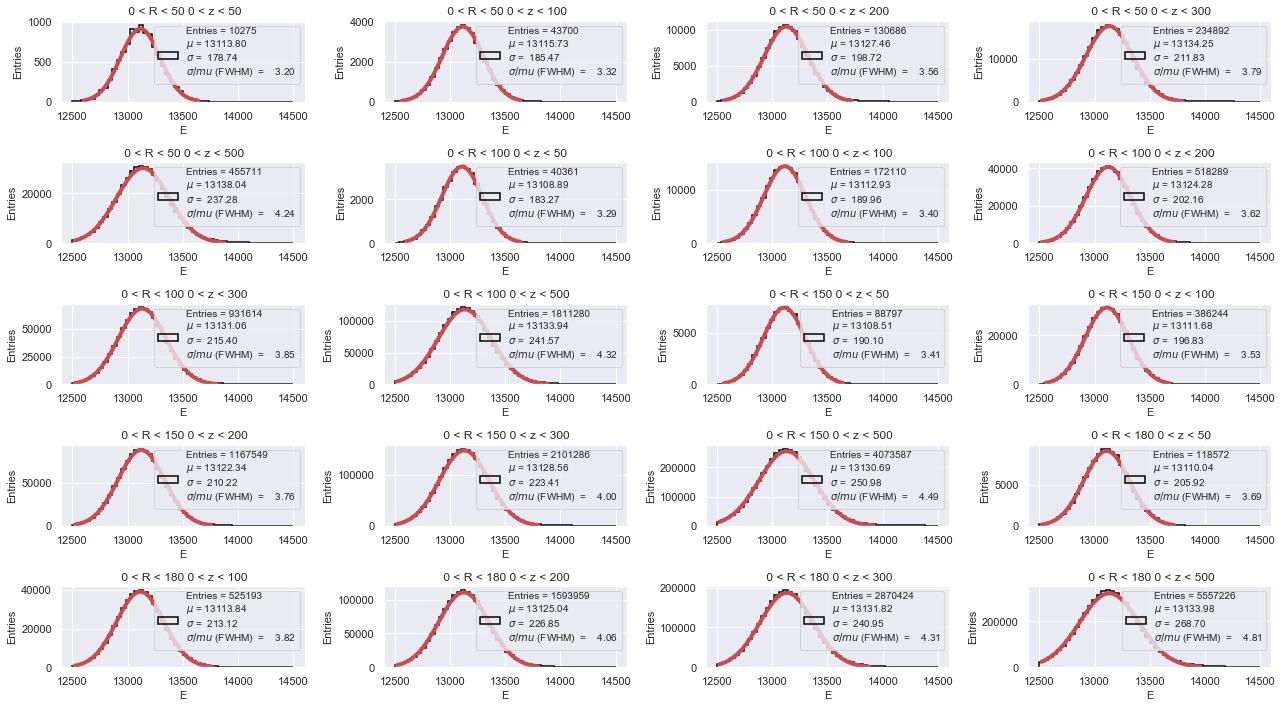

In [136]:
FC, FCE = resolution_r_z(Ri, Zi, dst.R, dst.ZS2, E,
                    enbins = 50,
                    erange = (12500,14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

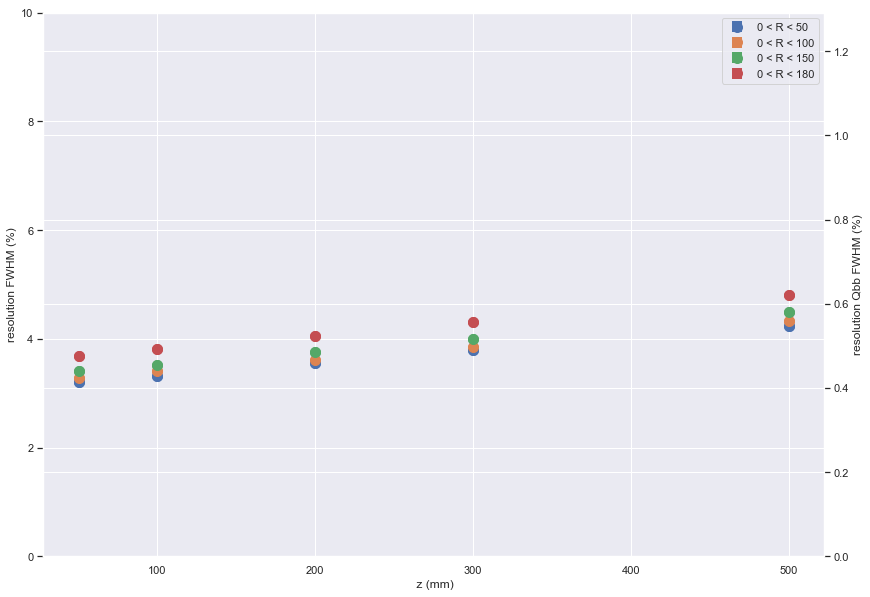

In [137]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

In [138]:
0.63/0.57

1.105263157894737